Anotaciones
===========

Uno de los atribútos más importante en aquellos modelos de aprendizaje automático supervisados es la variable a predecir o target. Esto en general lo llamamos "anotaciones". Dependiendo del problema que estamos tratando de resolver será el típo de anotaciones que deberemos suministrar. Notará que en algunos casos suministrar una anotación puede ser una tarea sencilla, pero en otros casos podría suponer una cantidad sustancial de tiempo e incluso y elemento de diseño de modelo de aprendizaje automático.

Veamos las peculariades de cada tipo de problema y algunos ejemplos de como trabajar estos conjuntos de datos en `tensorflow`

## Problemas de clasificación de objetos

En problemas de clasificación buscaremos predecir la clase a la que pertenece una imágen en particular. En general, estos conjuntos de datos suelen tener sus anotaciones de forma implicita en la estructura de directorios en la que están almacenados. De esta forma en un problemas de clasificación de barcos, la estructura de directorios podría ser de la siguiente forma:

```
Dataset/
├─ train/
│  ├─ carguero/
│  ├─ pesquero/
│  ├─ crucero/
│  ├─ navegacion/
│  └─ ...
└─ test/
   ├─ carguero/
   ├─ pesquero/
   ├─ crucero/
   ├─ navegacion/
   └─ ...
```

### Construyendo un conjunto de datos desde el directorio

La libreria `tensorflow-datasets` provee funcionalidades bastante sencillas de utilizar para poder acceder diferentes conjuntos de datos construidos a partir de directorios. Esta librería no es parte de la instalación base de `tensorflow` por lo tanto debemos instalarla. Desde pip podemos hacerlo de la siguiente forma:

```
pip install tensorflow-datasets
```

Si prefiere utilizar la API de Keras, puede utilizar el `namespace` `keras.preprocessing` con las clases `ImageDataGenerator` o `DirectoryIterator`.

In [ ]:
!pip install tensorflow-datasets

Descarguemos un conjunto de datos de ejemplo:

In [ ]:
!wget https://santiagxf.blob.core.windows.net/public/datasets-vision.zip --quiet --no-clobber
!unzip -qq datasets-vision.zip

Leemos el conjunto de datos

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='datasets/barcos/',
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=10, num_shards=1>,
    },
    citation="""""",
)


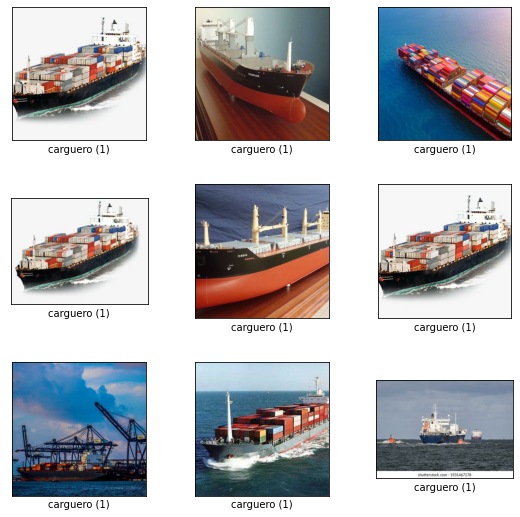

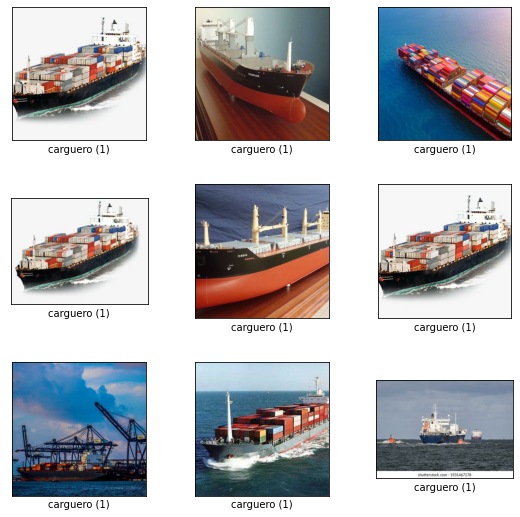

In [13]:
import tensorflow_datasets as tfds

builder = tfds.ImageFolder('datasets/barcos/')
ds = builder.as_dataset(split='train', shuffle_files=True)

print(builder.info)
tfds.show_examples(ds, builder.info)

Como podemos ver, el objeto dataset se encarga de descrubrir todas las propiedades del conjunto de datos incluyendo:

- Cantidad de clases
- Cantidad de particiones, como ser `train` o `test`
- Cantidad de archivos en cada clase y en cada partición.

El objeto también controla como el conjunto de datos es convertido a tensores e incluso si es necesario que las imagenes se retornen en forma aleatoria cuando se solicitan. 

### Clasificación multi-label

En el ejemplo anterior, donde los directorios representan las etiquetas, solo funcionará en casos donde cada imagen puede pertenecer solo a una clase (`binary` o `multi-class`). Para aquellos problemas donde más de una etiqueta corresponde a cada imágen (`multi-label`) deberemos utilizar otra técnica.

La siguiente función recibe un directorio donde se encuentra la imágen y sus respectivas etiquetas y devuelve un tensor:

In [17]:
import tensorflow as tf
from tensorflow.data.experimental import AUTOTUNE

def parse_image(filename, labels, CHANNELS:int=3, IMG_SIZE:int=224):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    
    return image_decoded, label

Esta función se puede utilizar luego para generar un `tf.data.Dataset` de la siguiente forma. Note que aqui estamos considerando que `filenames` es tensor que contiene los directorios donde se encuentran las imagenes y `labels` las etiquetas asociadas:

In [18]:
def create_dataset(filenames, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=AUTOTUNE)
    
    if is_training == True:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
        
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

> Nota: Para realizar un ejemplo que sea similar a la funcionalidad obtenida con `tensorflow-datasets`, se introdujeron algunas optimizaciones de performance como cache y prefetch durante la generación del conjunto de datos.

Podemos listar todas las imagenes en el directorio como sigue:

In [23]:
X_train = tf.data.Dataset.list_files('datasets/barcos/*/*/*')

In [24]:
for f in X_train.take(5):
    print(f.numpy())

b'datasets/barcos/train/carguero/barco_carguero(7).jpg'
b'datasets/barcos/train/carguero/barco_carguero(1).jpg'
b'datasets/barcos/train/carguero/barco_carguero(2).jpg'
b'datasets/barcos/train/carguero/barco_carguero.jpg'
b'datasets/barcos/train/carguero/barco_carguero(4).jpg'


Luego, combinamos las imagenes con sus etiquetas. Aqui `y_train` puede ser un arreglo de `numpy` conteniendo las diferentes etiquetas:

In [ ]:
train_ds = create_dataset(X_train, y_train, is_training=True)


Problemas de detección de objetos
---------------------------------

En los problemas de detección de objetos estamos interesados en obtener la ubicación específica de cada uno de los objetos dentro de una imágen. En estos problemas, las anotaciones se indican como "cajas" que continen el objeto en cuestión. Estas cajas se las suele llamar **bouding-boxes** o **ROI - Region of interest**.

### Formatos para anotaciones

En general, 2 formatos predominan para almacenar las anotaciones de modelos de detección de objetos:

- Pascal/VOC (Visual Object classification)
- COCO/YOLO

#### Pascal/VOC (Visual Object classification)

Pascal VOC esta diseñado para la detección de objetos y utiliza un archivo en formato `XML`. El formato supone la creación de un archivo para cada una de las imágenes en el conjunto de datos. Los elementos principales dentro del nodo `annotation` en este archivo `XML` son:

- folder: Carpeta que contiene las imágenes
- filename:Nombre del archivo físico que existe en la carpeta
- size: Contienen el tamaño de la imagen en términos de ancho, alto y profundidad. Si la imagen es en blanco y negro, la profundidad será 1. Para las imágenes en color, la profundidad será 3.
- object: Contiene los detalles del objeto. Si tiene varias anotaciones, se repite la etiqueta del objeto con su contenido. A su vez debemos indicar los siguientes nodos: 

    - name: Este es el nombre del objeto que estamos tratando de identificar.
    - truncated: Por ejemplo, si un objeto es visible parcialmente en la imagen, entonces configuramos truncado en 1. Si el objeto es completamente visible, configuramos truncado en 0.
    - difficult:Un objeto se marca como difícil cuando se considera que es difícil de reconocer. Si el objeto es difícil de reconocer, establecemos difícil en 1; de lo contrario, lo configuramos en 0
    - bndbox: Rectángulo que contiene el objeto en cuestión. Este formato indica las posiciones de las cajas como: `(xmin-top left, ymin-top left,xmax-bottom right, ymax-bottom right)`.

Pascal espera que los archivos esten ubicados de la siguiente forma:

```
data_dir
└─ year_dir
   ├─ Annotations
   |  └─ *.xml
   ├─ ImageSets
   |  └─ Main
   |    ├─ test.txt
   |    ├─ train.txt
   |    ├─ val.txt
   |    └─ trainval.txt
   └─ JPEGImages
      └─ *.jpg
```      

#### COCO/YOLO

El formato utilizado por COCO o el modelo YOLO almacena anotaciones en un archivo JSON el cual soporta tanto problemas de identificación de objetos como de segmentación. Este archivo es único para todo el conjnto de datos completo, incluyendo cada una de sus particiones de entrenamiento, validación o pruebas. Los elementos básicos para el archivo de anotaciones JSON son:

- info: contiene información de alto nivel sobre el conjunto de datos.
- licencies: contiene una lista de licencias de imágenes que se aplican a las imágenes del conjunto de datos.
- categories: contiene una lista de categorías. Cada categoría puede pertenecer a otra categoría creando así un arbol de categorías.
- images: contiene toda la información de las imagenes en el conjunto de datos sin contemplar las anotaciones.
- annotations: lista de cada anotación para cada imágen del conjunto de datos.

Bounding-box: A diferencia de Pascal, este formato indica las posiciones de cada caja como `(x-top left, y-top left, width, height)`.

### Generar y cargar las anotaciones

Existen muchas herramientas para generar estas anotaciones, hablaremos aquí de 2 alternativas: una utilizando una herramienta de nuve que resuelve la problematica, y la otra, utilizando una herramienta de código abierto. Dependiendo el contexto de la organización la opción que mejor se adaptará a las necesidades.

#### Utilizando herramientas de nube

Una alternativa muy interesante es utilizar alguna herramienta de anotaciones que no solo nos ayude a generar los conjuntos de datos, sino que nos permita interoperar en los diferentes formatos que hay para generar las anotaciones. Una de ellas, la cual es gratuita, es [roboflow](https://roboflow.ai).La misma ofrece mecanismos no solo para anotar los conjuntos de datos sino que también para descargarlos en multiples formatos:

<img src="_images/label_annotate.png" width="600" />

#### Utilizando una herramienta de codigo abierto

Existen multiples herramientas de código abierto, aunque una de las más sencillas de utilizar la librería `labelImg`.

```
pip install labelImg
```

El comando anterior instala la versión para linea de comandos en Ubuntu. Si dispone de un ambiente Windows, una opción muy cómoda es utilizar la interfaz de usuario. Puede descargarlo desde [http://tzutalin.github.io/labelImg/](http://tzutalin.github.io/labelImg/). Para utilizarlo, abra la herramiento y apunte al directorio donde tiene almacenadas las imágenes. La herramienta puede leer todos los directorios que están por debajo y que contienen imágenes.

En `labelImg` puede especificar el formato que desea utilizando la barra de herramientas lateral.

##### Creando anotaciones

Por cada imágen que necesita anotar, cree una nueva anotación utilizando la opción `Create RectBox`:

<img src="_images/label_add_tag.png" width="700" />

Cuando crea la anotaciones, deberá indicar la clase a la que pertenece. Por defecto la herramienta tiene precargadas algunas clases, pero puede crear sus propias sin problemas.

<img src="_images/label_edit_tag.png" width="500" />

Una vez que genere las anotaciones, deberá guardarlas presionando en "Save". **Para evitar tener que seleccionar siempre el directorio donde las desea almacenar, primero selecciona la opción "Change save directory"**

##### Ejemplo: Cargando las anotaciones en un conjunto de datos en TensorFlow <img src='../_images/wow.png' width='25'>

Una vez que tenemos la anotaciones generadas, deberíamos de poder cargarlas en un conjunto de datos. Es decir, ¿cómo disponer de una estructura de datos donde estén no solo las imágenes sino que también las anotaciones? Veamos un ejemplo de como lograr esto utilizando `TensorFlow`.

###### Instalando TensorFlow Object Detection API

In [34]:
!mkdir $HOME/repos/tensorflow

In [35]:
!git clone --depth 1 https://github.com/tensorflow/models $HOME/repos/tensorflow-models

Cloning into '/home/santiagxf/repos/tensorflow'...
remote: Enumerating objects: 2927, done.
remote: Counting objects: 100% (2927/2927), done.
remote: Compressing objects: 100% (2473/2473), done.
remote: Total 2927 (delta 738), reused 1238 (delta 416), pack-reused 0
Receiving objects: 100% (2927/2927), 33.01 MiB | 2.92 MiB/s, done.
Resolving deltas: 100% (738/738), done.


###### Instalando Protobuf

In [44]:
%%bash
cd  $HOME/repos/tensorflow-models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
pip install -q .

Escribimos el archivo donde indicamos las clases que estamos interesados en identificar:

In [175]:
%%writefile datasets/street-people/VOC2007/label-map.pbtxt

item {
 id: 1
 name: 'hat'
}

Overwriting datasets/street-people/VOC2007/label-map.pbtxt


Creamos el conjunto de entrenamiento creado un nuevo archivo con extension `txt` donde estan listados todos los nombres de las imágenes que forman parte del conjunto de entrenamiento.

In [131]:
!find datasets/street-people -name '*.xml' -exec basename {} .xml \; | sort -n > datasets/street-people/VOC2007/ImageSets/Main/aeroplane_train.txt

##### Convirtiendo las anotaciones a formato `TensorFlow` (`TFRecord`)

Convertimos este conjunto en tensores que se pueden utilizar con `tensorflow`

In [160]:
!python $HOME/repos/tensorflow-models/research/object_detection/dataset_tools/create_pascal_tf_record.py \
    --label_map_path=datasets/street-people/VOC2007/label-map.pbtxt \
    --data_dir=datasets/street-people \
    --year=VOC2007 \
    --set=train \
    --output_path=datasets/street-people/VOC2007/pascal_train.record

2021-10-04 16:01:41.813946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-04 16:01:41.813999: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-04 16:01:43.144213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-04 16:01:43.144305: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-04 16:01:43.144325: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (laptop): /proc/driver/nvidia/version does not exist
I1004 16:01:43.145156 140190115891008 create_pascal_tf_record.py:163] 

Intentemos abrir estos registros:

In [169]:
raw_dataset = tf.data.TFRecordDataset("datasets/street-people/VOC2007/pascal_train.record")

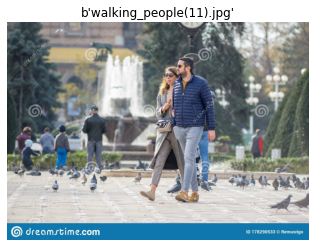

In [172]:
from matplotlib import pyplot as plt

raw_example = next(iter(raw_dataset))
parsed = tf.train.Example.FromString(raw_example.numpy())

feature = parsed.features.feature
raw_img = feature['image/encoded'].bytes_list.value[0]

img = tf.image.decode_png(raw_img)
plt.imshow(img)
plt.axis('off')
_ = plt.title(feature["image/filename"].bytes_list.value[0])

### Mejores prácticas a la hora de generar anotaciones

Si bien no existe una receta de oro para seguir, en general las siguientes prácticas dan buenos resultados:

- Disponga de al menos 100 imágenes por cada una de las categorías que desea utilizar.
- Es importante ser consistente en la forma que se dibujan los límites de los objetos. Cuanto más homogeneo es el criterio que se utiliza para asignar las áreas mejor. Por ejemplo, ¿Como etiquetamos los objetos que no son cuadrados?
- Cuando utilice múltiples etiquetas, debe haber un balanceo entre la cantidad de imágenes que tiene disponible en cada etiqueta para evitar conjunto de datos no balanceados. La relación debe ser al menos 2:1 entre la etiqueta con mayor cantidad de imágenes y la etiqueta con menor cantidad.
- Las imágenes deben tiene variedad en condiciones de iluminación, ángulos y fondos para que el modelo pueda generalizar correctamente.